**NEURAL NETWORKS: ASSIGNMENT 9.3<br>
Philip Georgis [s8phgeor]<br>
Pauline Sander [s8pasand]<br>
Vilém Zouhar [vizo00001]**<br>
Based on tutorial at: https://nextjournal.com/gkoehler/pytorch-mnist

LOAD REQUIRED MODULES

In [17]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

SET HYPERPARAMETERS, RANDOM SEED, and DISABLE NON-DETERMINISTIC ALGORITHMS

In [9]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
log_interval = 10

random_seed = 1
torch.manual_seed(random_seed)

torch.backends.cudnn.enabled = False

DOWNLOAD MNIST DATASET, PERFORM TRAIN/TEST SPLIT

In [3]:
#Load training set
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("",
                               train=True, #select train set
                               download=True, 
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)) #global mean and SD of MNIST dataset
                             ])),
    batch_size=batch_size_train,
    shuffle=True)

#Load test set
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('',
                               train=False, #select test set
                               download=True, 
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)) #global mean and SD of MNIST dataset
                             ])),
  batch_size=batch_size_test,
  shuffle=True)

BUILD CLASS FOR NEURAL NET MODEL

In [10]:
class Net(nn.Module):
    def __init__(self, name, dropout=False, l_norm=None, l_norm_lambda=None):
        super(Net, self).__init__() #inherits methods and attributes of parent class
        
        #Name of model
        self.name = name
        
        #Regularization parameters, if applicable
        self.dropout = dropout
        self.l_norm = l_norm
        self.l_norm_lambda = l_norm_lambda
        
        #First convolutional layer:
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        
        #Second convolutional layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        #Dropout layer: only if dropout is specified as True
        if self.dropout == True:
            self.conv2_drop = nn.Dropout2d()
        
        #First fully-connected layer
        self.fc1 = nn.Linear(320, 50)
        
        #Second fully-connected layer
        self.fc2 = nn.Linear(50, 10)
        
        #Store loss data for plotting
        self.train_losses = []
        self.train_counter = []
        self.test_losses = [] 
        self.test_counter = []
        
        
    def forward(self, x):
        """Carries out forward pass step"""
        #Feed forward through convolutional layers and apply 2D max pooling
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
        #Apply dropout if applicable
        if self.dropout == True:
            x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        else:
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
        
        #Reshape output of convolutional layers to match dimensions for FC1
        #-1 specifies that input to this will be an unknown shape (tensor of any size)
        x = x.view(-1, 320) 
        
        #Feed forward through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x) #no activation function on final layer
        
        #apply log softmax function to get (log) probability-like distribution
        #over possible classes (in this case: digits)
        return F.log_softmax(x, dim=1)

CREATE FUNCTIONS FOR TRAINING AND EVALUATING THE MODEL

In [11]:
def train(model, optimizer, epoch): 
    """Trains the specified model on the train_loader dataset using the
    specified optimizer"""
    
    #Set the model into training mode
    model.train()
    
    #Iterate over training data batches
    for batch_idx, (data, target) in enumerate(train_loader):
        
        #Set gradient to zero or else it would accumulate by default
        optimizer.zero_grad() 
        
        #Feed input data through network
        output = model(data)
        
        #Calculate negative log-likelihood loss between output and target label
        loss = F.nll_loss(output, target)
        
        #Add an Lp norm penalty to loss as regularization, if applicable
        if model.l_norm != None:
            fc2_parameters = torch.cat([x.view(-1) for x in model.fc2.parameters()])
            l_reg = model.l_norm_lambda * torch.norm(fc2_parameters, model.l_norm)**model.l_norm
            loss += l_reg
            
        #Backpropagate the loss
        loss.backward()
        
        #Adjust the weights for current step
        optimizer.step()
        
        #Print progress every 10 batches and store training loss and internal states
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( 
                epoch, batch_idx * len(data), len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), loss.item()))
            
            #Store training loss
            model.train_losses.append(loss.item())
            
            model.train_counter.append( 
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
            #Store internal states of model and optimizer: useful for if you want to continue training later
            torch.save(model.state_dict(), f'{model.name}.pth')
            torch.save(optimizer.state_dict(), f'{model.name} optimizer.pth')
            
            
def test(model):
    """Tests the specified model on the test_loader dataset"""
    
    #Set model into evaluation mode
    model.eval()
    
    #Iterate through test data, counting up loss and number of correctly identified items
    test_loss = 0
    correct = 0
    with torch.no_grad(): #don't calculate gradients while evaluating model
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    model.test_losses.append(test_loss)
    try:
        model.test_counter.append(max(model.test_counter)+len(train_loader.dataset))
    except ValueError:
        model.test_counter.append(0)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format( 
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def plot_loss(model):
    """Plots train and test loss over number of training examples seen"""
    plt.plot(model.train_counter, model.train_losses, color='blue')
    plt.scatter(model.test_counter, model.test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('Number of Training Examples Seen')
    plt.ylabel('Negative Log Likelihood Loss')
    title = f'{model.name} Network'
    plt.title(title)
    plt.savefig(f'{title}.png', dpi=100)
    plt.show()

**INITIALIZE SEVERAL MODELS**<br>

**Model 1: Vanilla SGD Model** (*no optimization or regularization*)<br><br>
In addition to the standard vanilla SGD model, we initialize the following:<br>
*Optimization*<br>
**Model 2: SGD Model with Momentum**<br>
**Model 3: Adaptive Moment Estimation (ADAM)**<br>
<br>
*Regularization*<br>
**Model 4: ADAM Model with Dropout**<br>
**Model 5: ADAM Model with L2 Norm Regularization**<br>

In [15]:
model1 = Net(name='Vanilla SGD')     
model1_optimizer = optim.SGD(model1.parameters(), lr=learning_rate)  

model2 = Net(name='SGD with Momentum')
model2_optimizer = optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9)

model3 = Net(name='Adaptive Moment Estimation (ADAM)')
model3_optimizer = optim.Adam(model3.parameters(), lr=learning_rate)

model4 = Net(name='Adaptive Moment Estimation (ADAM) with Dropout', dropout=True)
model4_optimizer = optim.Adam(model4.parameters(), lr=learning_rate)

model5 = Net(name='Adaptive Moment Estimation (ADAM) with L2 Norm Regularization', l_norm=2, l_norm_lambda=0.01)
model5_optimizer = optim.Adam(model5.parameters(), lr=learning_rate)

#List of the created models with their optimizers
model_list = [(model1, model1_optimizer),
              (model2, model2_optimizer),
              (model3, model3_optimizer),
              (model4, model4_optimizer),
              (model5, model5_optimizer)]

TRAIN AND TEST ALL 5 MODELS, AND PLOT THEIR LOSS RESULTS<br>
*(The plots are also saved in the working directory.)*

Testing Vanilla SGD model with randomly initiated parameters...

Test set: Avg. loss: 2.3110, Accuracy: 421/10000 (4%)

Training Vanilla SGD model (3 epochs)...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301890
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.313803
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.262345
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.269604
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.266507
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.247347
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.238072
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.198255
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.165028
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.174347
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.109632
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.014205
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.951301
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.890495
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.750836
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.521234
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.382742
Train Epoch: 1 [10

Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.080694
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.229942
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.039679
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.142183
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.075189
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.274044
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.139237
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.187405
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.093164
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.201485
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.078520
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.332997
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.123294
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.149078
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.075026
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.090796
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.162474
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.133111
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.089256
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.113921


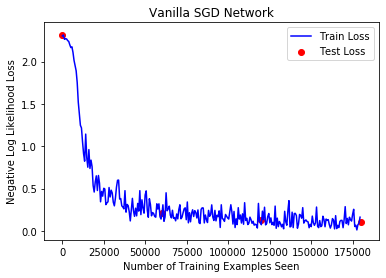

Testing SGD with Momentum model with randomly initiated parameters...

Test set: Avg. loss: 2.3049, Accuracy: 1135/10000 (11%)

Training SGD with Momentum model (3 epochs)...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300112
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.251575
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.122005
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.663797
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.900893
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.808367
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.709390
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.635085
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.287666
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.274282
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.344432
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.256838
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.158691
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.224957
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.268814
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.214112
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.411766
Trai

Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.041995
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.062551
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.013990
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.068549
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.090668
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.134670
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.088154
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.138659
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.060083
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.063308
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.098728
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.084526
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.016469
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.051281
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.053045
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.005035
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.081807
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.042936
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.018796
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.004982


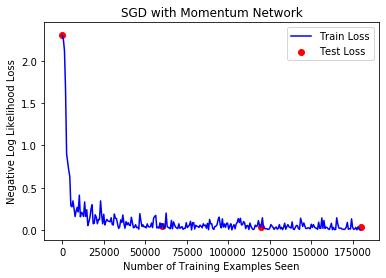

Testing Adaptive Moment Estimation (ADAM) model with randomly initiated parameters...

Test set: Avg. loss: 2.2996, Accuracy: 1313/10000 (13%)

Training Adaptive Moment Estimation (ADAM) model (3 epochs)...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.279786
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.193864
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.682625
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.241506
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.701408
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.218537
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.263720
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.276275
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.194703
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.224808
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.147760
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.103893
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.052775
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.169716
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.183149
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.184527
Train Epoch: 1 [10240/

Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.001604
Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.038544
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.058719
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.047459
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.120006
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.197034
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.036304
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.060876
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.128774
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.060564
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.041297
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.179579
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.144051
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.125299
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.144896
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.003242
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.019423
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.185636
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.004443
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.062417


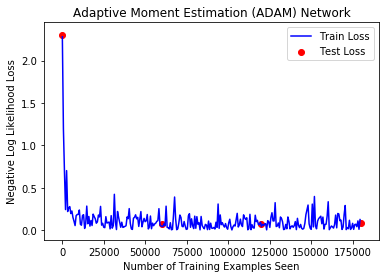

Testing Adaptive Moment Estimation (ADAM) with Dropout model with randomly initiated parameters...

Test set: Avg. loss: 2.3099, Accuracy: 1031/10000 (10%)

Training Adaptive Moment Estimation (ADAM) with Dropout model (3 epochs)...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324764
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.761846
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.800442
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.676412
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.023230
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.537807
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.471317
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.734177
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.583674
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.786757
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.436039
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.534123
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.235552
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.354952
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.408372
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.226

Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.068355
Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.224821
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.292428
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.261548
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.226116
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.140165
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.207656
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.190341
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.364492
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.061988
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.233455
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.301723
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.161949
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.074972
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.143501
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.262520
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.177700
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.201703
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.265995
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.201671


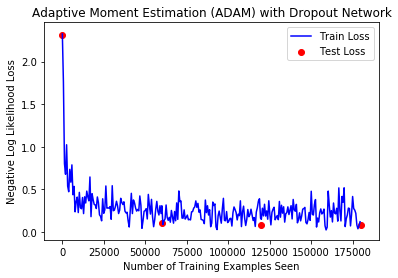

Testing Adaptive Moment Estimation (ADAM) with L2 Norm Regularization model with randomly initiated parameters...

Test set: Avg. loss: 2.3082, Accuracy: 987/10000 (10%)

Training Adaptive Moment Estimation (ADAM) with L2 Norm Regularization model (3 epochs)...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.353199
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.967778
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.560136
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.350617
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.188560
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.323771
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.299821
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.300525
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.261239
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.206262
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.133885
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.085017
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.116512
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.220500
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.295259
Train Epoch: 1 [

Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.040920
Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.074695
Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.018706
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.208161
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.248959
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.049868
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.102081
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.108385
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.019872
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.030230
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.228793
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.172779
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.140039
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.021880
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.179533
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.089881
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.023682
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.207065
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.137815
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.245400


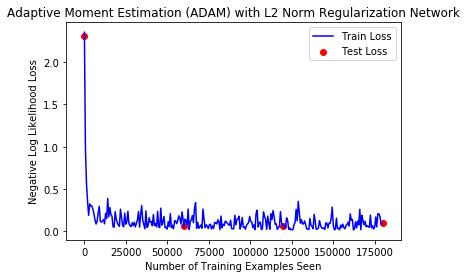

In [16]:
for model, optimizer in model_list:
    #Test model with randomly initialized parameters
    print(f'Testing {model.name} model with randomly initiated parameters...')
    test(model)
    
    #Train model and test over 3 epochs
    print(f'Training {model.name} model ({n_epochs} epochs)...')
    for epoch in range(1, n_epochs + 1):
        train(model, optimizer, epoch) 
        test(model) 
        
    #Plot train and test loss
    plot_loss(model)

**SUMMARY OF EVALUATION RESULTS**<br>
*Test accuracy after 3 training epochs*<br>
**Model 1 (Vanilla SDG):** 9662/10000 (97%)<br>
**Model 2 (SGD with Momentum):** 9885/10000 (99%)<br>
**Model 3 (ADAM):** 9770/10000 (98%)<br>
**Model 4 (ADAM + Dropout):** 9791/10000 (98%)<br>
**Model 5 (ADAM + L2 Norm Regularization):** 9699/10000 (97%)<br>
<br>
We observe that all 5 models seem to perform quite well on the test set. (However, such a high performance might be a sign that the model has actually overfitted on the data.)
<br>As expected, basic vanilla SGD performs the poorest, with the optimized and regularized models all achieving higher test accuracy. In terms of the optimized models, ADAM performs somewhat worse than SGD with momentum. We apply regularization techniques to this model in order to improve its performance. We observe that dropout regularization does slightly improve the performance in conjunction with ADAM optimization, but L2 norm regularization actually worsens the performance of the model.

We have seen that the optimal (best performing) model is SGD with momentum, which achieved 99% test accuracy.<br>
We can additionally get its F1 score, both averaged across all digit classes and for each class individually:

Average F1 Score: 0.988


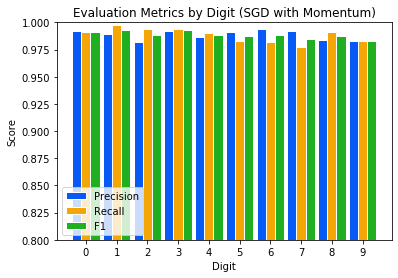

In [26]:
def f1_score_plot(model):
    test_data = enumerate(test_loader)
    
    #Create dictionary containing the predicted labels for each class in test data
    #and dictionary containing gold labels for each predicted class
    gold_digits = defaultdict(lambda:[])
    pred_digits = defaultdict(lambda:[])
    for i in range(len(test_loader)):
        batch_idx, (test_input, test_target) = next(test_data)
        test_output = model(test_input)
        test_output = test_output.data.max(1)[1]
        for j in range(len(test_target)):
            gold_digit = test_target[j].item()
            pred_digit = test_output[j].item()
            gold_digits[gold_digit].append(pred_digit)
            pred_digits[pred_digit].append(gold_digit)
    
    #Get the precision, recall, F1 score for each digit class
    TP, TN, FP, FN = {}, defaultdict(lambda:0), {}, {}
    precision, recall = {}, {}
    F1 = {}
    for digit in gold_digits:
        TP[digit] = len([pred for pred in gold_digits[digit] if pred == digit])    
        FP[digit] = len([gold for gold in pred_digits[digit] if gold != digit])
        FN[digit] = len([pred for pred in gold_digits[digit] if pred != digit])
        for other_digit in gold_digits:
            if other_digit != digit:
                TN[digit] += len([pred for pred in gold_digits[other_digit] if pred != digit])
        precision[digit] = TP[digit] / (TP[digit]+FP[digit])
        recall[digit] = TP[digit] / (TP[digit]+FN[digit])
        F1[digit] = (2*(precision[digit]*recall[digit])) / (precision[digit]+recall[digit])
    
    #Get the average F1 scores over all digit classes
    F1_average = sum(F1.values()) / len(F1.values())
    print(f'Average F1 Score: {round(F1_average, 3)}')
    
    #Create a plot displaying the precision, recall, and F1 scores per digit
    labels = sorted(list(F1.keys()))
    precisions = [precision[label] for label in labels]
    recalls = [recall[label] for label in labels]
    F1_scores = [F1[label] for label in labels]
    
    x = np.arange(len(labels))
    barWidth = 0.3
    r1 = np.arange(len(labels))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    plt.bar(r1, precisions, color='#075AF5', width=barWidth, edgecolor='white', label='Precision')
    plt.bar(r2, recalls, color='#F5A607', width=barWidth, edgecolor='white', label='Recall')
    plt.bar(r3, F1_scores, color='#1FAF21', width=barWidth, edgecolor='white', label='F1')
    plt.xlabel('Digit')
    plt.ylabel('Score')
    plt.ylim((0.8, 1.0))
    title = f'Evaluation Metrics by Digit ({model.name})'
    plt.title(title)
    plt.xticks([r + barWidth for r in range(len(labels))], labels)
    plt.legend(loc='lower left')
    plt.savefig(f'{title}.png', dpi=100)
    plt.show()
    
f1_score_plot(model2)

We can see that this model performs very well on all digits according to precision, recall, and F1 score. (Note that the y-axis scale begins from 0.8 in order for the differences among digits to be more clearly visible.) There do not seem to be any major imbalances in the model's predictive ability for each class.